<a href="https://colab.research.google.com/github/leolani/cltl-face-all/blob/master/examples/colab/4.ERC-MELD-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will train our simples models here together.

We'll start with the small pre-defined dataset.

## Clone the repo, download the necessary files, etc.

In [ ]:
%cd /content
!git clone https://github.com/leolani/cltl-face-all
!cd cltl-face-all/ && pip install .
!pip install omegaconf==2.0.5
!pip install tqdm av

# Download the annotations and stuff
!wget https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-small.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-medium.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/dataset-large.json
!wget https://raw.githubusercontent.com/leolani/cltl-face-all/master/examples/smaller-datasets-jsons/datasets.json

!gdown --id 1rsLbfgQYztDtrPFqEmkh-2d_0ap1qd_s
!unzip visual-features-smaller-dataset.zip
!rm visual-features-smaller-dataset.zip

!gdown --id 16ck7plW9v9eSHGCs5wuB2AhhufPRt3Wi
!unzip smaller-dataset.zip
!rm smaller-dataset.zip

!ls smaller-dataset/  |  wc -l
!ls visual-features-smaller-dataset | wc -l

/content
fatal: destination path 'cltl-face-all' already exists and is not an empty directory.
Processing /content/cltl-face-all
  Created wheel for cltl-face-all: filename=cltl_face_all-0.0.0-cp36-none-any.whl size=53234 sha256=0ac0ab7f48be5917cabf368336c66ee674b46b82e08524399f71dd4c242657b1
  Stored in directory: /root/.cache/pip/wheels/8d/71/f3/2db0b17856a0b395aaa04c8562716e0350cfc712cdd4b9947e
Successfully built cltl-face-all
  Found existing installation: cltl-face-all 0.0.0
    Uninstalling cltl-face-all-0.0.0:
      Successfully uninstalled cltl-face-all-0.0.0
--2020-12-10 17:15:17--  https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1119290 (1.1M) [text/plain]
Saving to: 

In [ ]:
import json

with open('datasets.json', 'r') as stream:
    datasets = json.load(stream)

datasets = datasets['large']

## Randomly select a video and play it



In [ ]:
from glob import glob
import random
import os
import json
import numpy as np
import av
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import HTML
from base64 import b64encode

VISUAL_FEATURES_PATH = 'visual-features-smaller-dataset/'
VIDEOS_PATH = "smaller-dataset/"

diautt = random.choice([foo for foo, bar in datasets['train'].items()])
annot = datasets['train'][diautt]
features_path = os.path.join(VISUAL_FEATURES_PATH, diautt) + '.npy'

features = np.load(features_path, allow_pickle=True)
# below line is necessary since the saved file is actually a dictionary.
features = features.item()

vid_path = os.path.join(VIDEOS_PATH, diautt) +  '.mp4'
container = av.open(vid_path)

print(vid_path)
print(annot)

frames = {}
for idx, frame in enumerate(container.decode(video=0)):
    numpy_RGB = np.array(frame.to_image())
    frames[idx] = numpy_RGB

assert np.abs(len(frames) - len(features)) <= 1

mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=1280 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Randomly select a frame and check it

In [ ]:
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=0.8, thickness=1):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)
    
idx = random.choice(list(frames.keys()))
img = frames[idx]
print(idx)

feature = features[idx]

for feat in feature:
    bbox = feat['bbox']
    landmark = feat['landmark']
    age = feat['age']
    gender = feat['gender']
    embedding = feat['embedding']
    # face = feat['face']

    x1, y1, x2, y2, prob = bbox
    
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    label = f"{str(round(prob*100, 1))} % face"
    draw_label(img, (x1, y2), label, font_scale=0.5, thickness=1)

    for lm in landmark:
        cv2.circle(img, (int(lm[0]), int(lm[1])), 1, (0,255,0), -1)

    label = f"{int(age)} years old, {str(round(gender*100, 1))} % female"
    draw_label(img, (x1, y1), label, font_scale=0.5, thickness=1)
    
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

for key, val in annot.items():
    print(key, '\t', val)

## The datasets structure

It has train, dev and test. 

In [ ]:
datasets.keys()

dict_keys(['train', 'dev', 'test'])

In [ ]:
for key, val in datasets.items():
    print(key, len(val))

train 173
dev 14
test 17


## Let's see how the data actually looks like

run the below cell.

In [ ]:
datasets['train']['dia1000_utt0']

{'Dialogue_ID': '1000',
 'Emotion': 'disgust',
 'EndTime': '00:06:49,783',
 'Episode': '3',
 'Season': '2',
 'Sentiment': 'negative',
 'Speaker': 'Monica',
 'SrNo': '10029',
 'StartTime': '00:06:45,780',
 'Utterance': 'Would you look at this dump? He hated us. This is his final revenge!',
 'Utterance_ID': '0'}

## Let's check out the data distributions.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

def count2ratio(counts):
    total_counts = sum([val for key, val in counts.items()])

    return {key: round(val/total_counts, 3) for key, val in counts.items()}

for key, val in datasets.items():
    sentiments = []
    emotions = []
    speakers = []

    for diautt, annot in val.items():
        sentiments.append(annot['Sentiment'])
        emotions.append(annot['Emotion'])
        speakers.append(annot['Speaker'])

    sentiments = dict(Counter(sentiments))
    emotions = dict(Counter(emotions))
    speakers = dict(Counter(speakers))

    sentiments = count2ratio(sentiments)
    emotions = count2ratio(emotions)
    speakers = count2ratio(speakers)

    print(key, 'sentiments', sentiments)
    print(key, 'emotions', emotions)
    print(key, 'speakers', sentiments)
    print()

When it comes to the emotion classes, you can see that the label `neutral` accounts for nearly half of the instances. **This means that if your emotion classifier performs less than the accuracy of 50%, you are doing something wrong.**



## **TODO0**: 
Down-sample the data. 

In [ ]:
import pandas as pd

BALANCE = True

def balance(train, method = ''):
    """
    Balances the classes by down-sampling.
    """
    df = pd.DataFrame(train).T

    if method == 'all':
        g = df.groupby('Emotion', group_keys=False)
        data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min())))
        return data.T.to_dict()
    
    elif method == 'halved':
        ### Separate the majority and minority classes
      df_minority  = df[df['Emotion']=='joy']
      df_majority = df[df['Emotion']=='neutral']
      df_rest = df[df['Emotion'] != 'neutral'][df['Emotion'] != 'joy']

      ### Now, downsamples majority labels equal to the number of samples in the minority class

      df_majority = df_majority.sample(len(df_minority), random_state=0)

      ### concat the majority and minority dataframes
      df = pd.concat([df_majority,df_minority, df_rest])

      ## Shuffle the dataset to prevent the model from getting biased by similar samples
      df = df.sample(frac=1, random_state=0)
      print(df['Emotion'].value_counts())
      return df.T.to_dict()

if BALANCE:
    datasets['balanced_train'] = balance(datasets['train'], method = 'halved')


joy         106
neutral     106
surprise     73
anger        53
sadness      48
disgust      15
fear         13
Name: Emotion, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## TODO1:

Extract viasual features or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Tae and Wes.

In [ ]:
import os
from glob import glob
import numpy as np
from cltl_face_all.arcface import calc_angle_distance
from tqdm.notebook import tqdm


predefined_faces_= glob(os.path.join('./cltl-face-all/your-faces/*/*.npy'))
predefined_faces = {}

for path in predefined_faces_:
    name = path.split('/')[-2]
    predefined_faces[name] = np.load(path)

vecs = {}
THRESHOLDS = {'face': 0.9, 'angle': 1.15}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs[DATASET] = {}
    for diautt, annot in datasets[DATASET].items():
        vecs[DATASET][diautt] = {}
        speaker = annot['Speaker']

        visual_features = np.load(f'visual-features-smaller-dataset/{diautt}.npy', \
                                    allow_pickle=True).item()

        for frame, features in visual_features.items():
            vecs[DATASET][diautt][frame] = None
            # Assume that there is only one unique face per frame.
            for feat in features:
                age = feat['age']
                gender = feat['gender']
                bbox = feat['bbox']
                embedding = feat['embedding']
                landmark = feat['landmark']

                if bbox[-1] < THRESHOLDS['face']:
                    continue

                if speaker not in list(predefined_faces.keys()):
                    continue

                embedding.reshape(1, 512)

                dists = {key: calc_angle_distance(embedding, val) for key, val \
                            in predefined_faces.items()}

                if dists[speaker] < THRESHOLDS['angle']:
                    vecs[DATASET][diautt][frame] = landmark


KeyboardInterrupt: ignored

In [ ]:
vecs_with_speaker = {}

for DATASET in tqdm(['train', 'dev', 'test']):
    vecs_with_speaker[DATASET] = {}

    print(f"{len(vecs[DATASET])} videos in {DATASET}")
    for diautt, frame_landmarks in vecs[DATASET].items():
        with_speaker = [lm for lm in frame_landmarks.values() if lm is not None]
        if len(with_speaker) > 0:
            vecs_with_speaker[DATASET][diautt] = with_speaker

    print(f"{len(vecs_with_speaker[DATASET])} videos in {DATASET}, after removing the utterances without the speaker face")
    print(f"the ratio is {len(vecs_with_speaker[DATASET]) / len(vecs[DATASET])}")
    print()

584 videos in train
517 videos in train, after removing the utterances without the speaker face
the ratio is 0.8852739726027398

97 videos in dev
81 videos in dev, after removing the utterances without the speaker face
the ratio is 0.8350515463917526

108 videos in test
94 videos in test, after removing the utterances without the speaker face
the ratio is 0.8703703703703703




In [ ]:
X = {}
y = {}

original_diautt = {}

emotion2num = {'anger': 0,
               'disgust': 1,
               'fear': 2,
               'joy': 3,
               'neutral': 4,
               'sadness': 5, 
               'surprise': 6}

num2emotion = {val: key for key, val in emotion2num.items()}
num2onehot = {0: np.array([1, 0, 0, 0, 0, 0, 0]),
              1: np.array([0, 1, 0, 0, 0, 0, 0]),
              2: np.array([0, 0, 1, 0, 0, 0, 0]),
              3: np.array([0, 0, 0, 1, 0, 0, 0]),
              4: np.array([0, 0, 0, 0, 1, 0, 0]),
              5: np.array([0, 0, 0, 0, 0, 1, 0]),
              6: np.array([0, 0, 0, 0, 0, 0, 1])}


for DATATYPE in ['train', 'dev', 'test']:
    X[DATATYPE] = []
    y[DATATYPE] = []
    original_diautt[DATATYPE] = []
    for diautt, landmarks in vecs_with_speaker[DATATYPE].items():
        label = datasets[DATATYPE][diautt]['Emotion']
        X[DATATYPE].append(landmarks)
        y[DATATYPE].append(num2onehot[emotion2num[label]])
        original_diautt[DATATYPE].append(diautt)


NameError: ignored

In [ ]:
import pickle

with open('compact-visual.pkl', 'wb') as stream:
    pickle.dump({'X': X, 'y': y, 'original_diautt': original_diautt}, stream)

In [ ]:
len(X['train']), len(X['train'][0]), X['train'][0][0].shape, y['train'][0], len(original_diautt['train'])

(517, 9, (68, 2), array([0, 1, 0, 0, 0, 0, 0]), 517)

## TODO2:

Extract text features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Nihat and Zeynep.

## Roberta Text Classification

In [ ]:
!pip install transformers==3.0.2

In [ ]:
# Transformers packages
import transformers
from transformers import RobertaModel, RobertaTokenizer
# Torch packages
import torch
from torch.utils.data import Dataset, DataLoader
from torch import cuda

# Check for the device
device = 'cuda' if cuda.is_available() else 'cpu'

### Embedding

[Text(0, 0, 'neutral'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'surprise'),
 Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'disgust'),
 Text(0, 0, 'fear')]

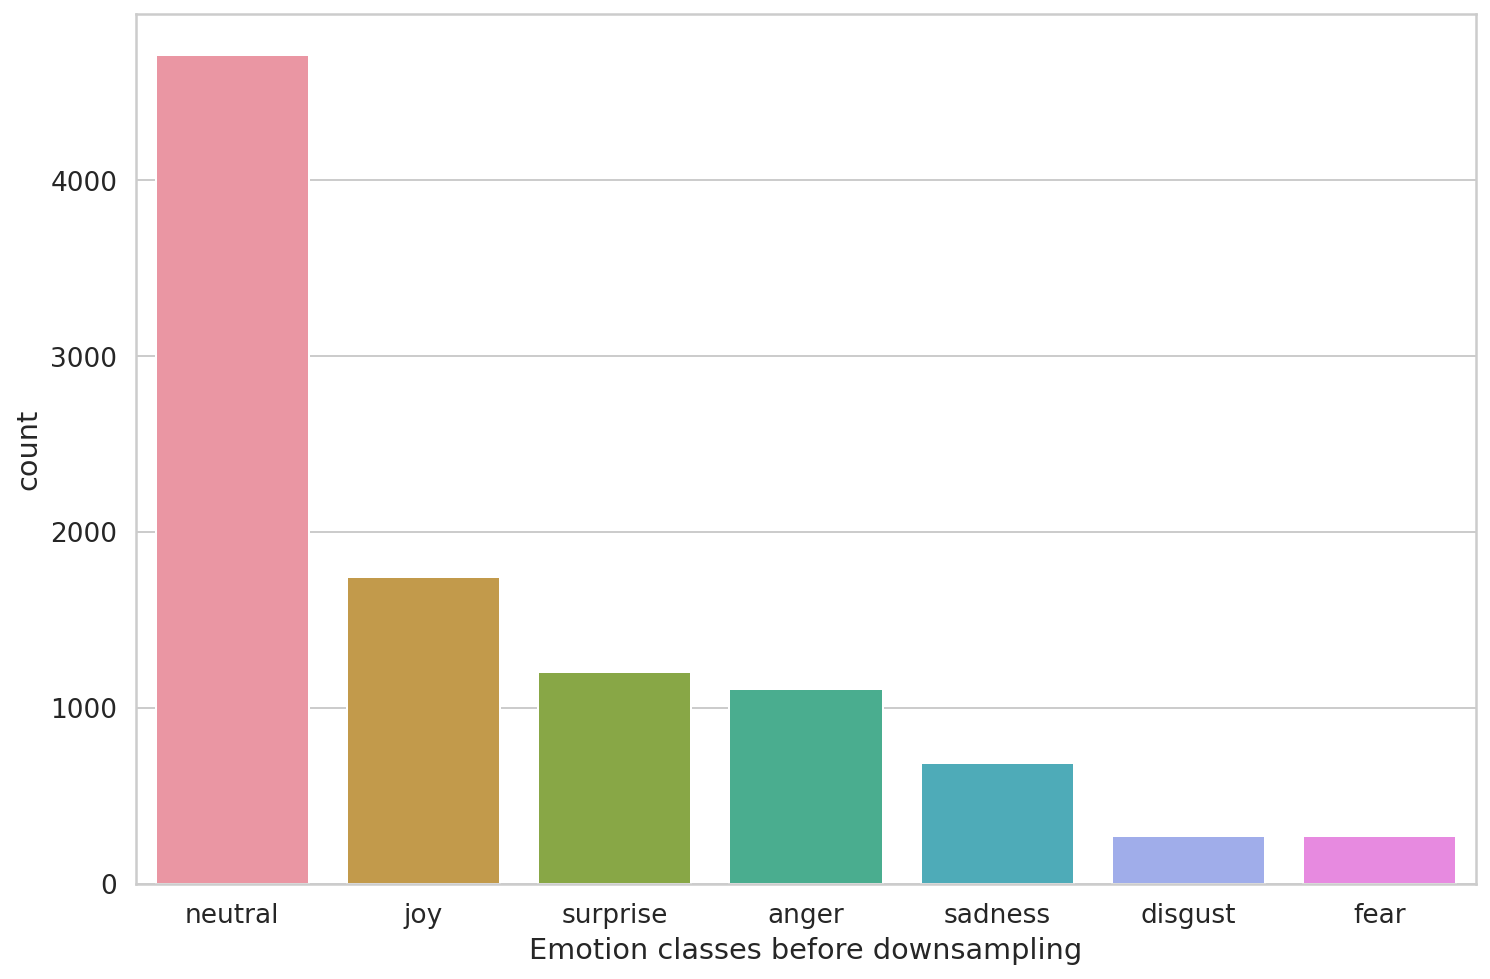

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import io

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Download data
download_train = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv').content
download_val = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/dev_sent_emo.csv').content
download_test = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/test_sent_emo.csv').content

# Create frames
df_train = pd.read_csv(io.StringIO(download_train.decode('utf-8')))
df_val = pd.read_csv(io.StringIO(download_val.decode('utf-8')))
df_test = pd.read_csv(io.StringIO(download_test.decode('utf-8')))

# Declare class names
class_names = [
    'neutral', 'joy', 'surprise', 'anger', 'sadness', 'disgust', 'fear'
]

def transform_labels(emotion):
    if emotion == 'neutral': return 0
    elif emotion == 'joy': return 1
    elif emotion == 'surprise': return 2
    elif emotion == 'anger': return 3
    elif emotion == 'sadness': return 4
    elif emotion == 'disgust': return 5
    elif emotion == 'fear': return 6

df_train['enc_emotion'] = df_train.Emotion.apply(transform_labels)
df_val['enc_emotion'] = df_val.Emotion.apply(transform_labels)
df_test['enc_emotion'] = df_test.Emotion.apply(transform_labels)

ax = sns.countplot(x=df_train.enc_emotion)
plt.xlabel('Emotion classes before downsampling')
ax.set_xticklabels(class_names)

In [ ]:
# Sort train set
df_train.sort_values(by=['Season', 'Episode', 'StartTime', 'EndTime'], inplace=True, ignore_index=True)
# Drop first 2710
df_train = df_train.drop(df_train[df_train['Emotion']=='neutral'].head(2710).index).reset_index()

# Defining some key variables that will be used later on in the training
MAX_LEN = 95
MODEL_NAME = "roberta-base"

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, truncation=True, do_lower_case=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


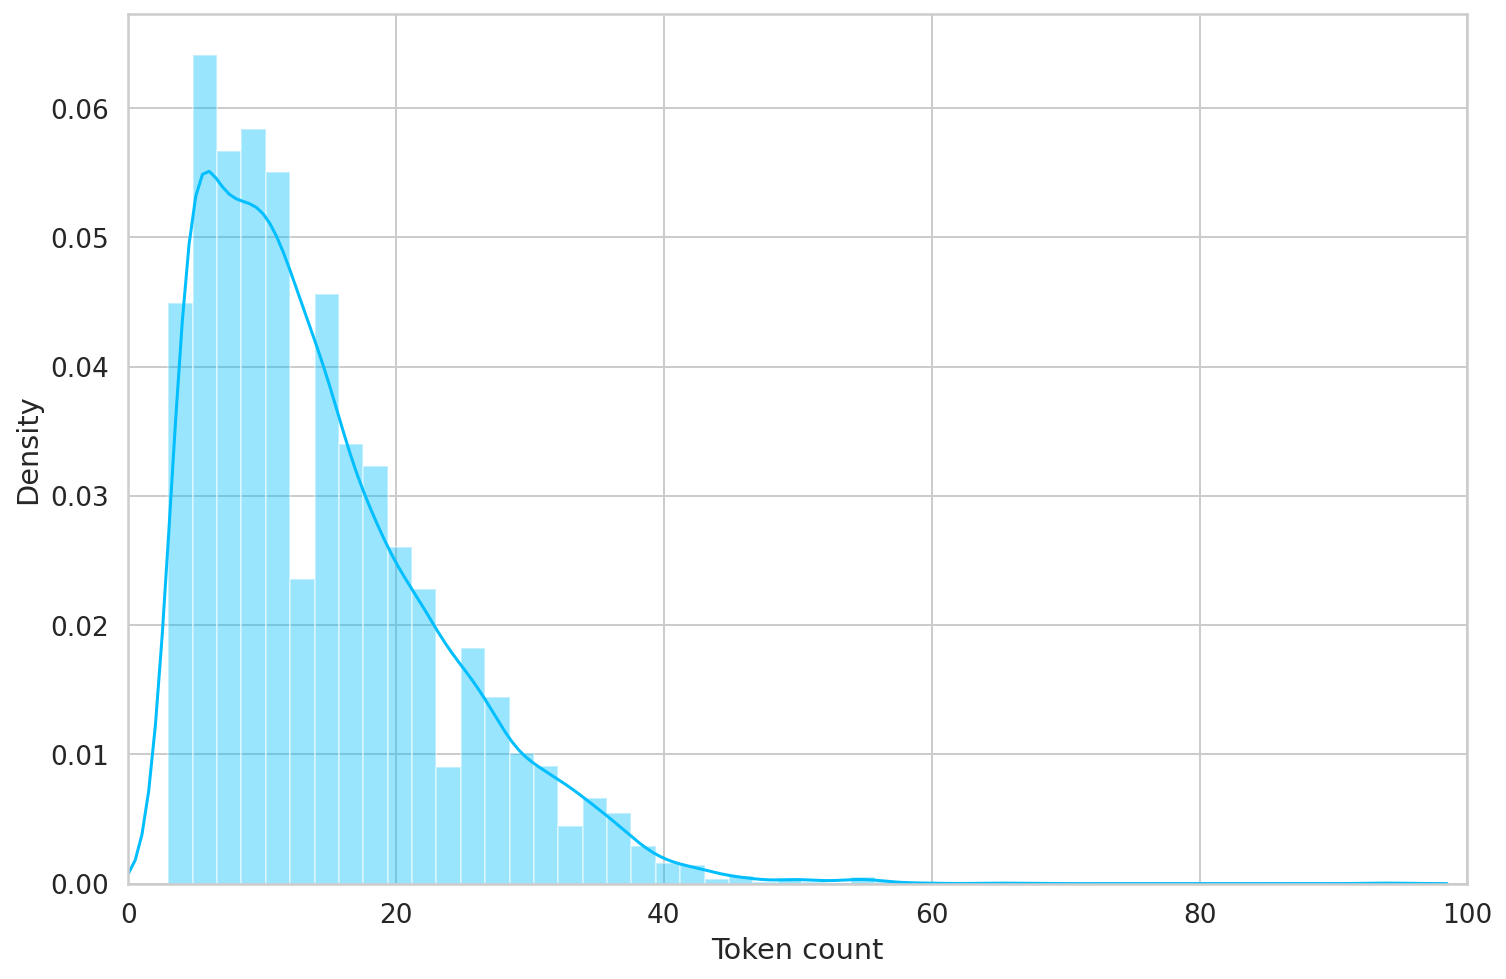

In [ ]:
# Print the token length distribution
token_lens = []
utterances = df_train.Utterance.to_numpy()

for txt in utterances:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


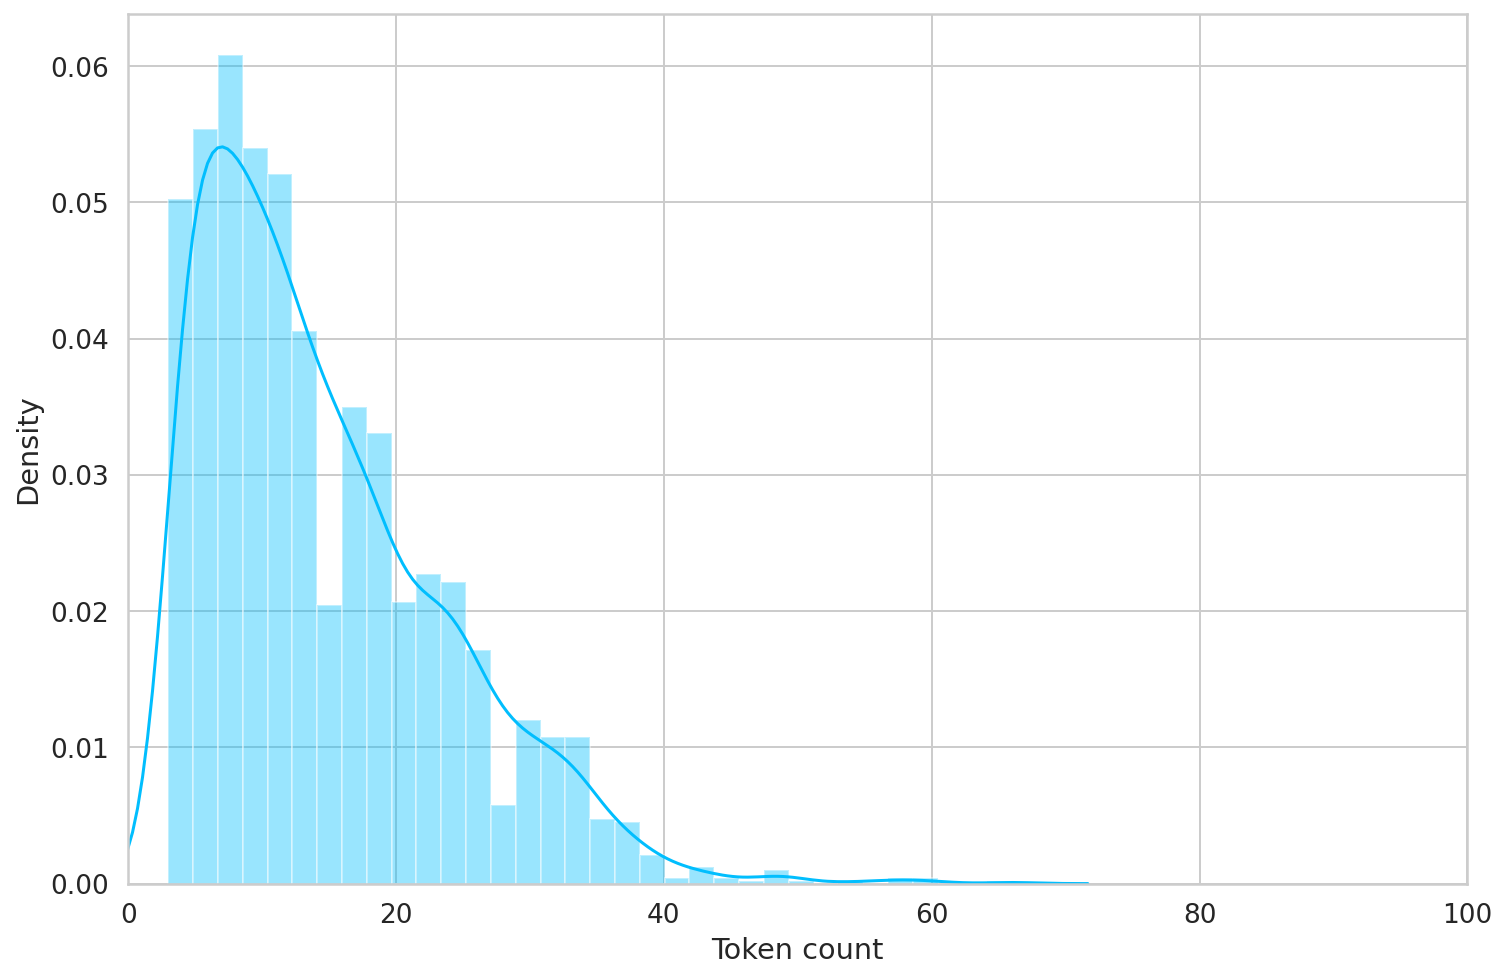

In [ ]:
# Print the token length distribution [test]
token_lens = []
utterances = df_test.Utterance.to_numpy()

for txt in utterances:
  tokens = tokenizer.encode(txt, truncation=True, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [ ]:
token_lens[np.argmax(token_lens)]

66

[Text(0, 0, 'neutral'),
 Text(0, 0, 'joy'),
 Text(0, 0, 'surprise'),
 Text(0, 0, 'anger'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'disgust'),
 Text(0, 0, 'fear')]

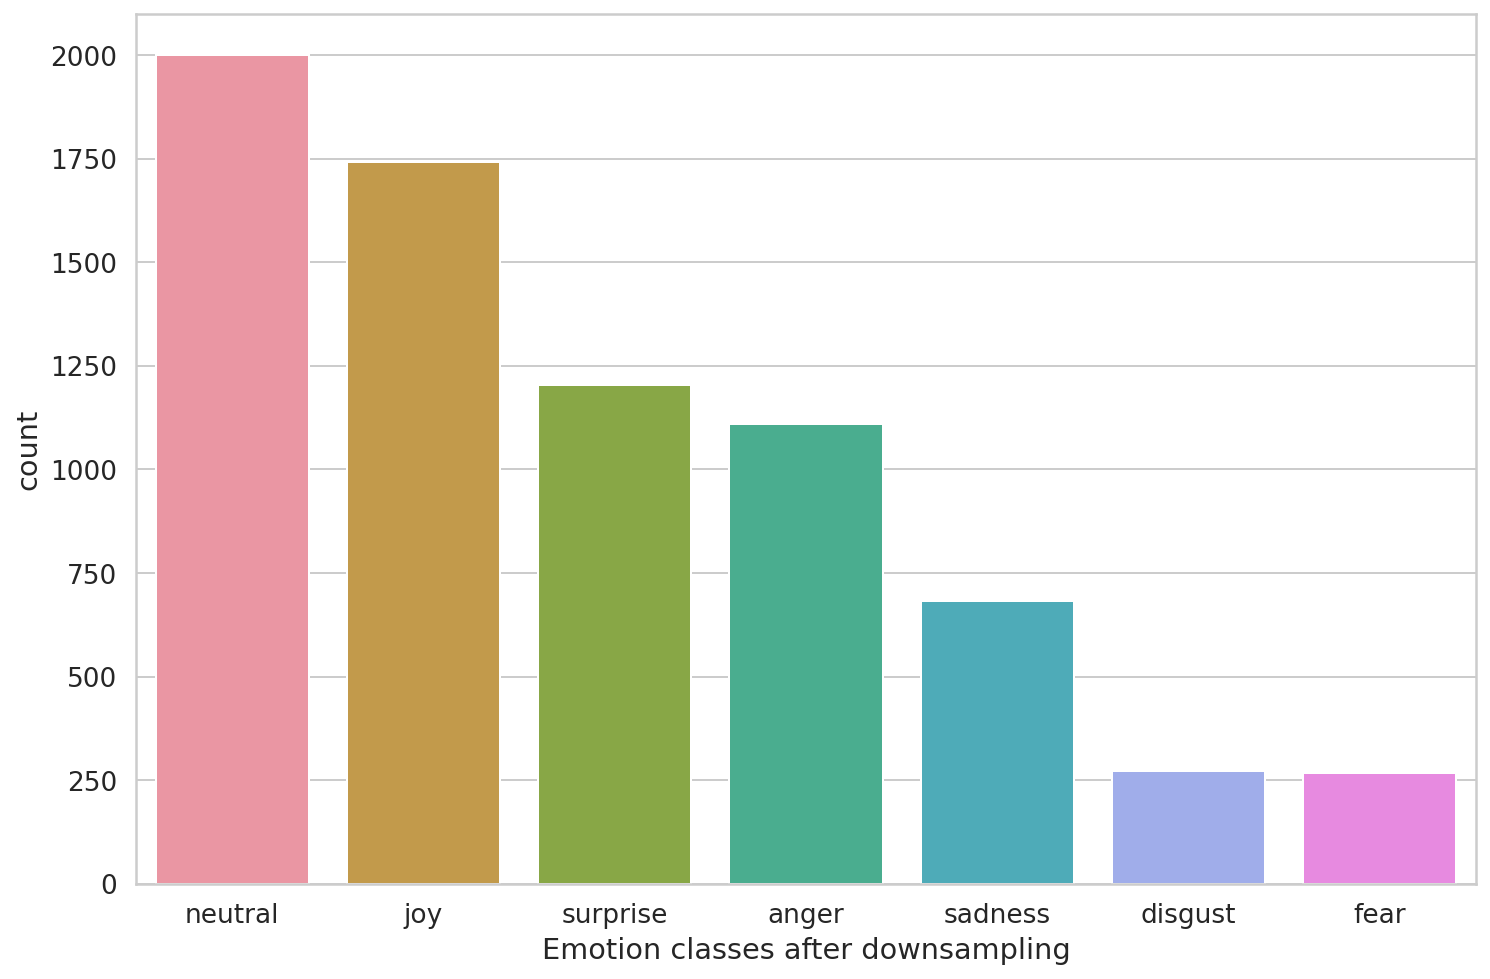

In [ ]:
ax = sns.countplot(x=df_train.enc_emotion)
plt.xlabel('Emotion classes after downsampling')
ax.set_xticklabels(class_names)

In [ ]:
def utterance_encode(utterance: str):
    inputs = tokenizer.encode_plus(
        utterance,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )

    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]

    return {
        'ids': torch.tensor(ids, dtype=torch.long).unsqueeze(0),
        'mask': torch.tensor(mask, dtype=torch.long).unsqueeze(0),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
    }

### Model

In [ ]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained('roberta-base')
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 7)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        # print(pooler.size())
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = RobertaClass().to(device=device)

In [ ]:
file_id = '1-0HL9o2tnNYUJwoVv1HMLj_NmY07kBu0' # '1--TzzCipxlgo17bWNhY0Z4rWNQWzFpMv' -> 256 length if needed
!gdown https://drive.google.com/uc?id={file_id}

# Load configs to the existing model
model.load_state_dict(torch.load('pytorch_roberta_sentiment.bin'))

Downloading...
From: https://drive.google.com/uc?id=1-0HL9o2tnNYUJwoVv1HMLj_NmY07kBu0
To: /content/pytorch_roberta_sentiment.bin
501MB [00:05, 97.0MB/s]


<All keys matched successfully>

In [ ]:
def predict_emotion(utterance) -> tuple:
    '''
    utterance: str
        The utterance text.
    
    Returns tuple.
        First item is the belonging class name.
        Second item is the encoded class name.
    '''
    # Encode inputs
    inputs = utterance_encode(utterance)
    # Parse into needed variables
    ids = inputs['ids'].to(device, dtype = torch.long)
    mask = inputs['mask'].to(device, dtype = torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype = torch.long)

    # Predict
    output = model(ids, mask, token_type_ids)
    _, prediction = torch.max(output, dim=1)

    return (output.to(torch.device("cpu")).detach().numpy(), class_names[prediction], prediction.item())

output, cls_name, index = predict_emotion("why you did that??")

In [ ]:
def tae(utterance) -> dict:
    '''
    utterance: str
        The utterance text.
    '''
    idx = {
        'anger': 0,
        'disgust': 1,
        'fear': 2,
        'joy': 3,
        'neutral': 4,
        'sadness': 5,
        'surprise': 6
    }

    # Encode inputs
    inputs = utterance_encode(utterance)
    # Parse into needed variables
    ids = inputs['ids'].to(device, dtype = torch.long)
    mask = inputs['mask'].to(device, dtype = torch.long)
    token_type_ids = inputs['token_type_ids'].to(device, dtype = torch.long)

    # Predict
    output = torch.nn.functional.softmax(model(ids, mask, token_type_ids), dim=1)
    _, prediction = torch.max(output, dim=1)

    return {
        'probs': output.to(torch.device("cpu")).detach().numpy(),
        'label': class_names[prediction],
        'index': idx[class_names[prediction]]
    }

tae("why you did that??")

{'index': 6,
 'label': 'surprise',
 'probs': array([[0.10603976, 0.05075339, 0.5761565 , 0.12183854, 0.05615963,
         0.04529101, 0.04376117]], dtype=float32)}

## TODO3:

Extract audio features  or train a classifier. Each video (utterance) should result in a fixed-size vector. This should be done by Vivian.



In [ ]:
! pip install librosa

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
# !unzip 'drive/My Drive/audio.zip'
!gdown --id 1e6HlcqfAjNOQJROtXn7gqcuPTGzu2KUk
!unzip audio.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/MELD.Raw/audio/train/dia228_utt3.mp3  
  inflating: content/MELD.Raw/audio/train/dia886_utt7.mp3  
  inflating: content/MELD.Raw/audio/train/dia363_utt1.mp3  
  inflating: content/MELD.Raw/audio/train/dia720_utt1.mp3  
  inflating: content/MELD.Raw/audio/train/dia1011_utt4.mp3  
  inflating: content/MELD.Raw/audio/train/dia418_utt18.mp3  
  inflating: content/MELD.Raw/audio/train/dia922_utt2.mp3  
  inflating: content/MELD.Raw/audio/train/dia49_utt9.mp3  
  inflating: content/MELD.Raw/audio/train/dia577_utt4.mp3  
  inflating: content/MELD.Raw/audio/train/dia361_utt11.mp3  
  inflating: content/MELD.Raw/audio/train/dia895_utt6.mp3  
  inflating: content/MELD.Raw/audio/train/dia390_utt2.mp3  
  inflating: content/MELD.Raw/audio/train/dia908_utt9.mp3  
  inflating: content/MELD.Raw/audio/train/dia654_utt5.mp3  
  inflating: content/MELD.Raw/audio/train/dia321_utt2.mp3  
  inflating: content/MELD.Raw/audio/train/dia52

In [ ]:
# Show random audio representation example of file
from scipy.io import wavfile as wav
import random
import os
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa.display


AUDIO_PATH = "smaller-dataset/"

diautt = random.choice([foo for foo, bar in datasets['train'].items()])
annot = datasets['train'][diautt]

print(annot)

audio_path = os.path.join(AUDIO_PATH, diautt) +  '.mp4'

def print_plot_play(x, Fs, text=''):
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

x, sr = librosa.load(audio_path)
print_plot_play(x=x, Fs=sr, text='MP4 file: ')

mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [ ]:
import requests 
import io
import pandas as pd

download_train = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/train_sent_emo.csv').content
download_val = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/dev_sent_emo.csv').content
download_test = requests.get('https://raw.githubusercontent.com/declare-lab/MELD/master/data/MELD/test_sent_emo.csv').content

# Create frames
df_train = pd.read_csv(io.StringIO(download_train.decode('utf-8')))
df_val = pd.read_csv(io.StringIO(download_val.decode('utf-8')))
df_test = pd.read_csv(io.StringIO(download_test.decode('utf-8')))

In [ ]:
from tqdm import tqdm
import librosa 
import numpy as np
import pandas as pd
from numpy import std

def get_features(df, dir, scaler = dict()):
    data = pd.DataFrame(columns=['feature'])
    label = pd.DataFrame(columns=['label'])
    name = pd.DataFrame(columns=['name'])    
  
    print(f'Number of rows in DataFrame: {len(df)}')

    for row in tqdm(df.itertuples()):
        
        try:
            path = f'./content/MELD.Raw/audio/{dir}/dia{row.Dialogue_ID}_utt{row.Utterance_ID}.mp3'
            y, sr = librosa.load(path, sr=None)

            result = np.array([])

            rmse = np.mean(librosa.feature.rmse(y=y))
            result = np.hstack((result, rmse))

            spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
            result = np.hstack((result, spec_cent))
            
            spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
            result = np.hstack((result, spec_bw))

            rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
            result = np.hstack((result, rolloff))

            zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
            result = np.hstack((result, zcr))

            ## MFCCs
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

            ## Chroma
            stft= np.abs(librosa.stft(y))
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
            result = np.hstack((result, chroma))

            ## Mel Scale
            mel = np.mean(librosa.feature.melspectrogram(y , sr=sr).T, axis=0)
            result = np.hstack((result, mel))

            label.loc[row.Index, 'label'] = df.loc[row.Index, 'Emotion']
            data.loc[row.Index] = [result]
            filename = 'dia'+ str(df.loc[row.Index, 'Dialogue_ID']) + '_utt' + str(df.loc[row.Index, 'Utterance_ID'])
            name.at[row.Index, 'name'] = filename

        except:
            print(f'failed for {row.Index}')

    final_data = pd.DataFrame(data['feature'].values.tolist(), index=data.index)
    if NORMALISE:
        for col in final_data:
            minimum = final_data[col].min(axis=0)
            maximum = final_data[col].max(axis=0)
            final_data[col] = final_data[col].apply(lambda x: (x - minimum) / (maximum - minimum))
            scaler[col] = (minimum, maximum)

    data = pd.concat([final_data, label, name], axis=1)
    data = data.sample(frac=1)

    return data, scaler

In [ ]:
NORMALISE=True

audio_train, scaler = get_features(df_train, 'train')
audio_dev, scaler = get_features(df_val, 'dev', scaler)
audio_test, scaler = get_features(df_test, 'test', scaler)

0it [00:00, ?it/s]

Number of rows in DataFrame: 1109


1085it [05:43,  4.25it/s]

failed for 1084


1109it [05:50,  3.16it/s]
0it [00:00, ?it/s]

Number of rows in DataFrame: 2610


2610it [15:38,  2.78it/s]


In [ ]:
# !gdown --id 1eFAHRypj9RH7pm0d5oJBFHJnaZWEo_uA
# !unzip Downloads.zip
# !rm -rf submissions\ \(2\)
# !rm -rf submissions\ \(3\)

# import pandas as pd

# audio_train = pd.read_csv('full_audio_train.csv')
# audio_dev = pd.read_csv('full_audio_dev.csv')
# audio_test = pd.read_csv('full_audio_test.csv')

Downloading...
From: https://drive.google.com/uc?id=1eFAHRypj9RH7pm0d5oJBFHJnaZWEo_uA
To: /content/Downloads.zip
37.1MB [00:00, 42.8MB/s]
Archive:  Downloads.zip
  inflating: full_audio_dev.csv      
  inflating: full_audio_test.csv     
  inflating: full_audio_train.csv    
  inflating: full_audio_train_balanced.csv  
  inflating: full_audio_train_balanced_all.csv  


In [ ]:
audio_train.to_csv('full_audio_train.csv', index=False)
audio_dev.to_csv('full_audio_dev.csv', index=False)
audio_test.to_csv('full_audio_test.csv', index=False)

from google.colab import files
files.download('full_audio_train.csv')
files.download('full_audio_dev.csv')
files.download('full_audio_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# BALANCE CLASSES
BALANCE = True
ALL = False

def balance(df, BALANCE, ALL):
  if BALANCE:
    # Balance classes for through down-sampling)
    if ALL:
        print(df.columns)
        g = df.groupby('label', group_keys=False)
        df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)
    else:  
        ### Separate the majority and minority classes
        df_minority  = df[df['label']=='joy']
        df_majority = df[df['label']=='neutral']
        df_rest = df[df['label'] != 'neutral'][df['label'] != 'joy']

        ### Now, downsamples majority labels equal to the number of samples in the minority class

        df_majority = df_majority.sample(len(df_minority), random_state=0)

        ### concat the majority and minority dataframes
        df = pd.concat([df_majority,df_minority, df_rest])

        ## Shuffle the dataset to prevent the model from getting biased by similar samples
        df = df.sample(frac=1, random_state=0)

    return df

    #train_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()))).reset_index(drop=True)

balanced_train = balance(audio_train, BALANCE, ALL)
balanced_train.to_csv('full_audio_train_balanced.csv', index=False)
#files.download('full_audio_train_balanced.csv')

balanced_train['label'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


neutral     1743
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: label, dtype: int64

# Actual audio model building


---

Fully connected deep neural network


In [ ]:
from keras import models
from keras import layers
from keras.layers import Dropout

model_v = models.Sequential()
model_v.add(layers.Dense(185, activation='relu', input_shape=(185,)))
model_v.add(Dropout(0.5))
model_v.add(layers.Dense(128, activation='relu'))
model_v.add(Dropout(0.5))
model_v.add(layers.Dense(64, activation='relu'))
model_v.add(Dropout(0.25))
model_v.add(layers.Dense(7, activation='softmax'))

model_v.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_v.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 185)               34410     
_________________________________________________________________
dropout_3 (Dropout)          (None, 185)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               23808     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                

In [ ]:
balanced_train = pd.read_csv('./full_audio_train_balanced.csv')


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train = np.array(balanced_train.drop(['label', 'name'], axis=1))
y_train = balanced_train['label'].tolist()

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

X_dev = np.array(audio_dev.drop(['label', 'name'], axis=1))
y_dev = audio_dev['label'].tolist()
y_dev = encoder.transform(y_dev)

X_test = np.array(audio_test.drop(['label', 'name'], axis=1))
y_test = audio_test['label'].tolist()
y_test = encoder.transform(y_test)

Epoch 1/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7132 - accuracy: 0.2964 - val_loss: 1.6806 - val_accuracy: 0.3042
Epoch 2/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7099 - accuracy: 0.2962 - val_loss: 1.6897 - val_accuracy: 0.3177
Epoch 3/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7109 - accuracy: 0.2951 - val_loss: 1.6731 - val_accuracy: 0.3276
Epoch 4/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7122 - accuracy: 0.2971 - val_loss: 1.7081 - val_accuracy: 0.3394
Epoch 5/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7159 - accuracy: 0.2894 - val_loss: 1.7266 - val_accuracy: 0.2662
Epoch 6/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7054 - accuracy: 0.2991 - val_loss: 1.6871 - val_accuracy: 0.3177
Epoch 7/100
586/586 [==============================] - 2s 3ms/step - loss: 1.7097 - accuracy: 0.2989 - val_loss: 1.7036 - val_accuracy: 0.3475

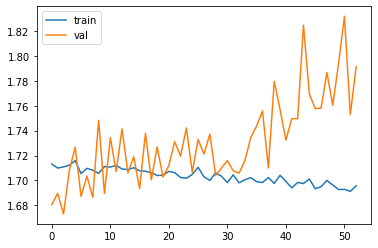

In [ ]:
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model_v.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_data = (X_dev, y_dev),
                    batch_size=12,
                    callbacks = [es])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model_v.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

82/82 [==============================] - 0s 2ms/step - loss: 1.8303 - accuracy: 0.2962
test_acc:  0.29616859555244446


In [ ]:
ypred = model_v.predict_classes(X_test)
from sklearn.metrics import classification_report

print(classification_report(y_test, ypred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[3 4 0 ... 4 4 0]
              precision    recall  f1-score   support

           0       0.20      0.57      0.30       345
           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        50
           3       0.17      0.26      0.20       402
           4       0.58      0.33      0.42      1256
           5       0.00      0.00      0.00       208
           6       0.19      0.18      0.18       281

    accuracy                           0.30      2610
   macro avg       0.16      0.19      0.16      2610
weighted avg       0.35      0.30      0.29      2610



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TODO4:

Concatenate the three feature vectors and/or train a simple classifier. Start simple (e.g. one-layered logistic regression). This should be done all together.

I (Viv) would propose the following structure for the voting system.


1.   **Scenario 1**: Each modality outputs the same emotion --> pick this emotion.
2.   **Scenario 2**: Two modalities output the same emotion --> pick this emotion.
3.   **Scenario 3**: Each modality outputs a different emotion. Depending on which of the three initial base models performs best (likely video or text?), select this option.



Modality fusion

In [ ]:
import os
from tqdm.notebook import tqdm
import json

if not os.path.isfile('datasets.json'):
    !gdown --id 1LG06KGcjJf6Efs1FGlQxz_NG_A8iWHE-
with open('datasets.json', 'r') as stream:
    datasets = json.load(stream)

emotion2num = {'anger': 0,
               'disgust': 1,
               'fear': 2,
               'joy': 3,
               'neutral': 4,
               'sadness': 5, 
               'surprise': 6}

from sklearn.metrics import classification_report, f1_score

In [ ]:
audio_features = {'train': {}, 'dev': {}, 'test': {}}

for idx, sample in tqdm(audio_train.iterrows()):
    label = sample['label']
    diautt = sample['name']
    feat = np.array(sample[:-2]).astype(np.float)
    feat = feat.reshape(1,-1)

    audio_features['train'][diautt] = feat

for idx, sample in tqdm(audio_dev.iterrows()):
    label = sample['label']
    diautt = sample['name']
    feat = np.array(sample[:-2]).astype(np.float)
    feat = feat.reshape(1,-1)

    audio_features['dev'][diautt] = feat

for idx, sample in tqdm(audio_test.iterrows()):
    label = sample['label']
    diautt = sample['name']
    feat = np.array(sample[:-2]).astype(np.float)
    feat = feat.reshape(1,-1)

    audio_features['test'][diautt] = feat

In [ ]:
predictions_probs_text = {}
predictions_probs_audio = {}

truths = {}

for DATASET in tqdm(['train', 'dev', 'test']):
    predictions_probs_text[DATASET] = {}
    predictions_probs_audio[DATASET] = {}
    
    truths[DATASET] = {}

    for diautt, annot in tqdm(datasets[DATASET].items()):
        t =  emotion2num[annot['Emotion']]

        try:
            p_audio = model_v.predict(audio_features[DATASET][diautt].reshape(1, -1))
            p_text = tae(datasets[DATASET][diautt]['Utterance'])['probs']

            p_text = p_text[0,3], p_text[0,5], p_text[0,6], p_text[0,1], p_text[0,0], p_text[0,4], p_text[0,2] 
            p_text = np.array(p_text).reshape(1,7)

            predictions_probs_audio[DATASET][diautt] = p_audio
            predictions_probs_text[DATASET][diautt] = p_text
            truths[DATASET][diautt] = t

        except Exception as e:
            print(e)


'dia125_utt3'



### performance of audio alone

In [ ]:
for DATASET in tqdm(['train', 'dev', 'test']):
    print(f"*************** {DATASET} ***************")
    y_pred = [np.argmax(foo) for foo in list(predictions_probs_audio[DATASET].values())]
    y_true = [foo for foo in truths[DATASET].values()]
    print(classification_report(y_true, y_pred))
    print(f"weighted f1 score: ", f1_score(y_true, y_pred, average='weighted'))

*************** train ***************
              precision    recall  f1-score   support

           0       0.31      0.33      0.32      1109
           1       0.00      0.00      0.00       271
           2       0.00      0.00      0.00       268
           3       0.21      0.42      0.28      1743
           4       0.56      0.61      0.58      4709
           5       0.00      0.00      0.00       683
           6       0.36      0.08      0.12      1205

    accuracy                           0.40      9988
   macro avg       0.21      0.20      0.19      9988
weighted avg       0.38      0.40      0.37      9988

weighted f1 score:  0.37345158101874015
*************** dev ***************
              precision    recall  f1-score   support

           0       0.24      0.24      0.24       153
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        40
           3       0.16      0.61      0.26       163
           4      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### performance on text alone

In [ ]:
for DATASET in tqdm(['train', 'dev', 'test']):
    print(f"*************** {DATASET} ***************")
    y_pred = [np.argmax(foo) for foo in list(predictions_probs_text[DATASET].values())]
    y_true = [foo for foo in truths[DATASET].values()]
    print(classification_report(y_true, y_pred))
    print(f"weighted f1 score: ", f1_score(y_true, y_pred, average='weighted'))

*************** train ***************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.42      0.65      0.51      1109
           1       0.62      0.02      0.04       271
           2       0.00      0.00      0.00       268
           3       0.72      0.53      0.61      1743
           4       0.76      0.87      0.81      4709
           5       0.43      0.47      0.45       683
           6       0.79      0.56      0.66      1205

    accuracy                           0.67      9988
   macro avg       0.54      0.44      0.44      9988
weighted avg       0.67      0.67      0.66      9988

weighted f1 score:  0.6566283655271358
*************** dev ***************
              precision    recall  f1-score   support

           0       0.35      0.47      0.40       153
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        40
           3       0.66      0.52      0.58       163
           4       0.68      0.86      0.76       469
   

### FUSION!!!

In [ ]:
predictions_fusion = {'dev': {}}
performance_fusion = {'dev': {}}
f1_weighted_fusion = {'dev': {}}
for alpha in np.arange(0, 1, 0.05):

    y_true = []
    y_pred = []

    for diautt, t in truths['dev'].items():
        prob_text = predictions_probs_text['dev'][diautt]
        prob_audio = predictions_probs_audio['dev'][diautt]

        prob_fusion = prob_text * alpha + prob_audio* (1-alpha)
        # print(f"{np.argmax(prob_text)}, {np.argmax(prob_audio)}, {np.argmax(prob_fusion)}, {t}")
        predict_fusion = np.argmax(prob_fusion)
        y_true.append(t)
        
        y_pred.append(predict_fusion)

    performance_fusion['dev'][alpha] = classification_report(y_true, y_pred)
    f1_weighted_fusion['dev'][alpha] = f1_score(y_true, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for alpha, performance in performance_fusion['dev'].items():
    print('----------------------------------------------')
    print(f"alpha: {round(alpha, 3)}")
    print(performance)
    print('----------------------------------------------')

----------------------------------------------
alpha: 0.0
              precision    recall  f1-score   support

           0       0.24      0.24      0.24       153
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        40
           3       0.16      0.61      0.26       163
           4       0.49      0.36      0.42       469
           5       0.00      0.00      0.00       111
           6       0.38      0.02      0.04       150

    accuracy                           0.28      1108
   macro avg       0.18      0.18      0.14      1108
weighted avg       0.32      0.28      0.25      1108

----------------------------------------------
----------------------------------------------
alpha: 0.05
              precision    recall  f1-score   support

           0       0.25      0.26      0.25       153
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        40
           3       0.2

In [ ]:
for key, val in f1_weighted_fusion['dev'].items():
    print(round(key, 3), '\t', round(val,5))

0.0 	 0.37345
0.05 	 0.43978
0.1 	 0.51131
0.15 	 0.55854
0.2 	 0.58587
0.25 	 0.60889
0.3 	 0.62449
0.35 	 0.63779
0.4 	 0.6431
0.45 	 0.64992
0.5 	 0.6527
0.55 	 0.65505
0.6 	 0.65602
0.65 	 0.65694
0.7 	 0.65602
0.75 	 0.65616
0.8 	 0.65719
0.85 	 0.65721
0.9 	 0.65688
0.95 	 0.65673


alpha = 0.85 is the best for dev. let's check out the test!!!

In [ ]:
alpha = 0.7
for DATASET in ['train', 'dev', 'test']:
    y_true = []
    y_pred = []
    for diautt, t in truths[DATASET].items():
        prob_text = predictions_probs_text[DATASET][diautt]
        prob_audio = predictions_probs_audio[DATASET][diautt]
        prob_fusion = prob_text * alpha + prob_audio* (1-alpha)
        predict_fusion = np.argmax(prob_fusion)

        y_true.append(t)        
        y_pred.append(predict_fusion)

    print(classification_report(y_true, y_pred))
    print(f"weighed f1: ", f1_score(y_true, y_pred, average='weighted'))

              precision    recall  f1-score   support

           0       0.43      0.66      0.52      1109
           1       0.33      0.00      0.01       271
           2       0.00      0.00      0.00       268
           3       0.72      0.54      0.62      1743
           4       0.75      0.88      0.81      4709
           5       0.47      0.42      0.44       683
           6       0.79      0.55      0.65      1205

    accuracy                           0.68      9988
   macro avg       0.50      0.44      0.44      9988
weighted avg       0.66      0.68      0.66      9988

weighed f1:  0.6560185848997651
              precision    recall  f1-score   support

           0       0.37      0.54      0.44       153
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        40
           3       0.66      0.54      0.59       163
           4       0.69      0.87      0.77       469
           5       0.51      0.28      0.36   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
